In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import psycopg2
import logging
from dotenv import find_dotenv, load_dotenv
import sys
import os

# Set up logging
logging.basicConfig(
    stream=sys.stdout,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    level=logging.INFO,
)
log = logging.getLogger(__name__)

# Load environment variables
load_dotenv(find_dotenv(), override=True)

# Initialize DataFrames outside the try block
disbursement = pd.DataFrame()
repayments = pd.DataFrame()

# Database connection
connection = psycopg2.connect(
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    database=os.getenv("DB_NAME"),
)

try:
    with connection.cursor() as cursor:
        log.info("Connected to the database")
        # Fetch disbursement data and load into pandas DataFrame
        cursor.execute("SELECT * FROM public.disbursements")  # No schema prefix needed
        disbursement_data = cursor.fetchall()
        disbursement = pd.DataFrame(disbursement_data)
        disbursement.columns = [desc[0] for desc in cursor.description]
        # print(disbursement.head())

        # Fetch repayments data and load into pandas DataFrame
        cursor.execute("SELECT * FROM public.repayments")  # No schema prefix needed
        repayments_data = cursor.fetchall()
        repayments = pd.DataFrame(repayments_data)
        repayments.columns = [desc[0] for desc in cursor.description]
        # print(repayments.head())
        
        log.info("Data loaded successfully")
except Exception as e:
    log.error(f"Error: {e}")


# Aggregate profit/loss by month
disbursement['disb_date'] = pd.to_datetime(disbursement['disb_date']).dt.date
repayments['date_time'] = pd.to_datetime(
    repayments['date_time'],
    format='%d-%b-%y %I.%M.%S.%f %p', 
    errors='coerce'
).dt.date

# Extract month from date
disbursement['month'] = pd.to_datetime(disbursement['disb_date']).dt.to_period('M')
repayments['month'] = pd.to_datetime(repayments['date_time']).dt.to_period('M')

# Compute profit (sum of repayments - sum of loans disbursed)
profit_loss = repayments.groupby('month')['amount'].sum() - disbursement.groupby('month')['loan_amount'].sum()
profit_loss = profit_loss.reset_index()
profit_loss['month'] = profit_loss['month'].astype(str)
profit_loss.set_index('month', inplace=True)

2025-03-19 16:09:23,766 - __main__ - INFO - Connected to the database
2025-03-19 16:09:23,969 - __main__ - INFO - Data loaded successfully


/Users/omondidenzel/Desktop/Credable/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/omondidenzel/Desktop/Credable/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/omondidenzel/Desktop/Credable/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/omondidenzel/Desktop/Credable/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate sta

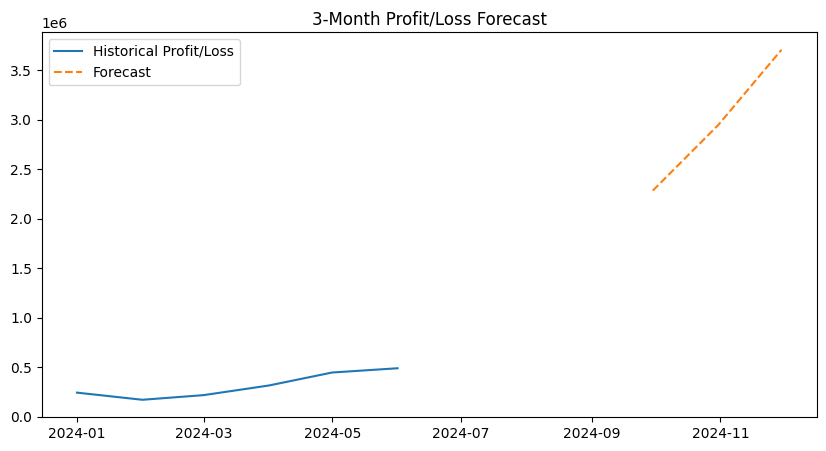

In [20]:
# Convert index to datetime
profit_loss.index = pd.to_datetime(profit_loss.index)

# Fit ARIMA Model
model = ARIMA(profit_loss, order=(2,1,2))  # ARIMA(p,d,q)
model_fit = model.fit()

# Forecast next 3 months
forecast_steps = 3
forecast = model_fit.forecast(steps=forecast_steps)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(profit_loss, label="Historical Profit/Loss")
plt.plot(pd.date_range(start=profit_loss.index[-1], periods=forecast_steps+1, freq='M')[1:], forecast, label="Forecast", linestyle="dashed")
plt.legend()
plt.title("3-Month Profit/Loss Forecast")
plt.show()
